In [1]:
%config Completer.use_jedi = False # use autocompletion

import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import detectron2
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_util
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.engine import BestCheckpointer
from detectron2.checkpoint import DetectionCheckpointer
# import PyCOCO tools
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

setup_logger()

<Logger detectron2 (DEBUG)>

## Fix issues with livecell annotations

In [2]:
# annDir=Path('sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell')
# types = ['train', 'test', 'val']

# for t in types:
#     p = annDir/f'livecell_coco_{t}.json'
#     with open(p, "r") as f:
#         j = json.load(f)
#     j['annotations'] = list(j["annotations"].values())
#     with open(p, 'w+') as json_file:
#         json.dump(j, json_file)

## Training


### Load the competition data

Copy live images to train directory

In [3]:
# !cp sartorius-cell-instance-segmentation/LIVECell_dataset_2021/images/livecell_train_val_images/SHSY5Y sartorius-cell-instance-segmentation/train *
# !cp sartorius-cell-instance-segmentation/LIVECell_dataset_2021/images/livecell_test_images/SHSY5Y sartorius-cell-instance-segmentation/train *

Load live data

In [4]:
# with open('sartorius-cell-instance-segmentation-coco/annotations_train.json', 'r') as f:
#     sartorius_train = json.load(f)

# with open('sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell_single_cells/shsy5y/livecell_shsy5y_train.json', 'r') as f:
#     sartorius_train_live_shsy5y = json.load(f)
# del sartorius_train_live_shsy5y['info']
# del sartorius_train_live_shsy5y['licenses']
# with open('sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell_single_cells/shsy5y/livecell_shsy5y_val.json', 'r') as f:
#     sartorius_val_live_shsy5y = json.load(f)
# del sartorius_val_live_shsy5y['info']
# del sartorius_val_live_shsy5y['licenses']
# with open('sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell_single_cells/shsy5y/livecell_shsy5y_test.json', 'r') as f:
#     sartorius_test_live_shsy5y = json.load(f)
# del sartorius_test_live_shsy5y['info']
# del sartorius_test_live_shsy5y['licenses']

Process live data to become compatible with train data

In [5]:
# for i in sartorius_train_live_shsy5y['images']:
#     del i['url']
#     del i['original_filename']
#     i['id'] = str(i['id'])
#     i['file_name'] = 'train/' + i['file_name']

# sartorius_train_live_shsy5y['annotations'] = list(sartorius_train_live_shsy5y['annotations'].values())
# for a in sartorius_train_live_shsy5y['annotations']:
#     a['category_id'] = 3
#     a['image_id'] = str(a['image_id'])
    
    
# for i in sartorius_val_live_shsy5y['images']:
#     del i['url']
#     del i['original_filename']
#     i['id'] = str(i['id'])
#     i['file_name'] = 'train/' + i['file_name']
    
# sartorius_val_live_shsy5y['annotations'] = list(sartorius_val_live_shsy5y['annotations'].values())
# for a in sartorius_val_live_shsy5y['annotations']:
#     a['category_id'] = 3
#     a['image_id'] = str(a['image_id'])
    
    
# for i in sartorius_test_live_shsy5y['images']:
#     del i['url']
#     del i['original_filename']
#     i['id'] = str(i['id'])
#     i['file_name'] = 'train/' + i['file_name']
    
# sartorius_test_live_shsy5y['annotations'] = list(sartorius_test_live_shsy5y['annotations'].values())
# for a in sartorius_test_live_shsy5y['annotations']:
#     a['category_id'] = 3
#     a['image_id'] = str(a['image_id'])

Merge live and train data

In [6]:
# sartorius_train_full = {'images': [], 'annotations': [], 'categories': []}
# sartorius_train_full['categories'] = sartorius_train['categories']

# for json_dict in [sartorius_train, sartorius_train_live_shsy5y, sartorius_val_live_shsy5y, sartorius_test_live_shsy5y]:
#     for k in json_dict.keys():
#         if k != 'categories':
#             sartorius_train_full[k].extend(json_dict[k])

Save merged data in json file

In [7]:
# with open('sartorius-cell-instance-segmentation-coco/annotations_full_train.json', 'w+') as f:
#     json.dump(sartorius_train_full, f)

In [8]:
dataDir=Path('sartorius-cell-instance-segmentation')

# register_coco_instances('sartorius_train',{}, 'sartorius-cell-instance-segmentation-coco/annotations_full_train.json', dataDir)
register_coco_instances('sartorius_train',{}, 'sartorius-cell-instance-segmentation-coco/annotations_train.json', dataDir)
register_coco_instances('sartorius_val',{},'sartorius-cell-instance-segmentation-coco/annotations_val.json', dataDir)

# register_coco_instances('sartorius_train_live',{}, 'sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_train.json', dataDir)
# register_coco_instances('sartorius_val_live',{}, 'sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_val.json', dataDir)
# register_coco_instances('sartorius_test_live',{}, 'sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_test.json', dataDir)

metadata = MetadataCatalog.get('sartorius_train')
train_ds = DatasetCatalog.get('sartorius_train')
val_ds = DatasetCatalog.get('sartorius_val')

# metadata_live = MetadataCatalog.get('sartorius_train_live')
# train_ds_live = DatasetCatalog.get('sartorius_train_live')
# train_val_live = DatasetCatalog.get('sartorius_val_live')
# train_test_live = DatasetCatalog.get('sartorius_test_live')

[12/07 15:43:54 d2.data.datasets.coco]: Loaded 484 images in COCO format from sartorius-cell-instance-segmentation-coco/annotations_train.json
[12/07 15:43:54 d2.data.datasets.coco]: Loaded 122 images in COCO format from sartorius-cell-instance-segmentation-coco/annotations_val.json


### Display a sample file to check the data is loaded correctly

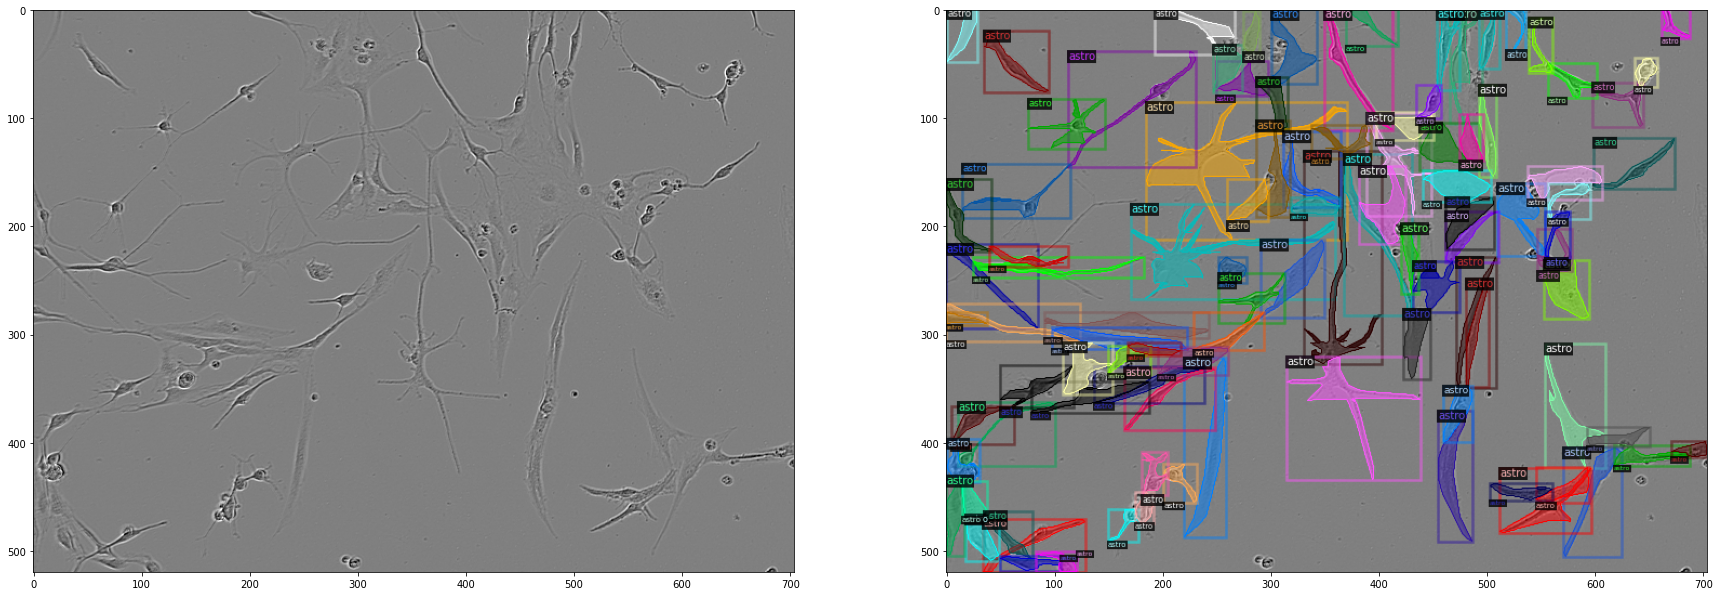

In [9]:
_, axs = plt.subplots(1, 2, figsize=(30, 20))

d = train_ds[42]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
out = visualizer.draw_dataset_dict(d)
axs[0].imshow(img)
axs[1].imshow(out.get_image()[:, :, ::-1])
plt.show()

### Define augmentation and evaluator 
Generates lines like this in the training output:
`[10/27 18:31:26 d2.evaluation.testing]: copypaste: MaP IoU=0.2192638391201311` 

See here for definition: https://www.kaggle.com/c/sartorius-cell-instance-segmentation/overview/evaluation

The dataset is transformed by changing the brighness and flipping the image with 50% probability...etc

In [10]:
def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
            T.RandomBrightness(0.9, 1.1),
            T.RandomContrast(0.9, 1.1),
            T.RandomSaturation(0.9, 1.1),
            T.RandomLighting(0.9),
            T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
            T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

# Taken from https://www.kaggle.com/theoviel/competition-metric-map-iou
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}

class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)
    
    def build_hooks(self):

        # copy of cfg
        cfg = self.cfg.clone()

        # build the original model hooks
        hooks = super().build_hooks()

        # add the best checkpointer hook
        hooks.insert(-1, BestCheckpointer(cfg.TEST.EVAL_PERIOD, 
                                         DetectionCheckpointer(self.model, cfg.OUTPUT_DIR),
                                         "MaP IoU",
                                         "max",
                                         ))
        return hooks
    
    
class AugTrainer(Trainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

# Train 

Training for 26 epochs

In [11]:
cfg = get_cfg()
cfg.INPUT.MASK_FORMAT='bitmask'

# cfg.merge_from_file(model_zoo.get_config_file("Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sartorius_train",)
cfg.DATASETS.TEST = ("sartorius_val",)

# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml")  # Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
# cfg.MODEL.WEIGHTS ="../input/detectron2cell/output/model_final.pth"

cfg.SOLVER.IMS_PER_BATCH = 1
cfg.DATALOADER.NUM_WORKERS = 2
    
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .5

cfg.SOLVER.BASE_LR = 5e-3
cfg.SOLVER.GAMMA = 0.1 
#cfg.SOLVER.MOMENTUM = 0.9
#cfg.SOLVER.WEIGHT_DECAY = 0.0005

# num of epochs is MAX_ITER * IMS_PER_BATCH / TOTAL_NUM_IMAGES = 12000 * 1 / 484
num_epochs = 26

cfg.SOLVER.WARMUP_ITERS = 10 # How many iterations to go from 0 to reach base LR
# cfg.SOLVER.MAX_ITER = 12000
cfg.SOLVER.MAX_ITER = num_epochs * len(DatasetCatalog.get('sartorius_train')) // cfg.SOLVER.IMS_PER_BATCH
cfg.SOLVER.STEPS = [18 * len(DatasetCatalog.get('sartorius_train')) // cfg.SOLVER.IMS_PER_BATCH] # At which point to change the LR to 5e-4, 5e-5
# cfg.TEST.EVAL_PERIOD = 500
cfg.TEST.EVAL_PERIOD = len(DatasetCatalog.get('sartorius_train')) // cfg.SOLVER.IMS_PER_BATCH  # Once per epoch


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = AugTrainer(cfg) # with  data augmentation  
trainer = Trainer(cfg) # without data augmentation
trainer.resume_or_load(resume=False)
trainer.train()

[12/07 15:43:57 d2.data.datasets.coco]: Loaded 484 images in COCO format from sartorius-cell-instance-segmentation-coco/annotations_train.json
[12/07 15:43:57 d2.data.datasets.coco]: Loaded 484 images in COCO format from sartorius-cell-instance-segmentation-coco/annotations_train.json
[12/07 15:43:58 d2.data.datasets.coco]: Loaded 484 images in COCO format from sartorius-cell-instance-segmentation-coco/annotations_train.json
[12/07 15:44:17 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_late

[12/07 15:44:17 d2.data.datasets.coco]: Loaded 484 images in COCO format from sartorius-cell-instance-segmentation-coco/annotations_train.json
[12/07 15:44:17 d2.data.build]: Removed 0 images with no usable annotations. 484 images left.
[12/07 15:44:17 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   astro    | 8429         |    cort    | 8662         |   shsy5y   | 42668        |
|            |              |            |              |            |              |
|   total    | 59759        |            |              |            |              |
[12/07 15:44:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[12/07 15:44:17 d2.data.build]: Using t

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[12/07 15:44:20 d2.engine.train_loop]: Starting training from iteration 0


/home/alex/anaconda3/envs/sartorius/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/07 15:44:35 d2.utils.events]:  eta: 1:22:28  iter: 19  total_loss: 2.59  loss_cls: 0.681  loss_box_reg: 0.3782  loss_mask: 0.5906  loss_rpn_cls: 0.6003  loss_rpn_loc: 0.3396  time: 0.4259  data_time: 0.0437  lr: 0.005  max_mem: 3794M
[12/07 15:44:44 d2.utils.events]:  eta: 1:21:47  iter: 39  total_loss: 2.663  loss_cls: 0.7239  loss_box_reg: 0.6601  loss_mask: 0.4149  loss_rpn_cls: 0.4357  loss_rpn_loc: 0.374  time: 0.4205  data_time: 0.0137  lr: 0.005  max_mem: 3794M
[12/07 15:44:53 d2.utils.events]:  eta: 1:23:28  iter: 59  total_loss: 2.046  loss_cls: 0.4246  loss_box_reg: 0.6131  loss_mask: 0.3486  loss_rpn_cls: 0.2701  loss_rpn_loc: 0.3654  time: 0.4371  data_time: 0.0505  lr: 0.005  max_mem: 3880M
[12/07 15:45:03 d2.utils.events]:  eta: 1:28:22  iter: 79  total_loss: 1.993  loss_cls: 0.5411  loss_box_reg: 0.4681  loss_mask: 0.3693  loss_rpn_cls: 0.2745  loss_rpn_loc: 0.3316  time: 0.4549  data_time: 0.0522  lr: 0.005  max_mem: 4198M
[12/07 15:45:13 d2.utils.events]:  eta: 1:2

[12/07 15:48:47 d2.engine.defaults]: Evaluation results for sartorius_val in csv format:
[12/07 15:48:47 d2.evaluation.testing]: copypaste: MaP IoU=0.16574617525494323
[12/07 15:48:47 d2.engine.hooks]: Saved first model at 0.16575 @ 483 steps
[12/07 15:48:54 d2.utils.events]:  eta: 1:27:02  iter: 499  total_loss: 1.877  loss_cls: 0.4755  loss_box_reg: 0.5705  loss_mask: 0.3132  loss_rpn_cls: 0.1165  loss_rpn_loc: 0.2718  time: 0.4923  data_time: 0.0262  lr: 0.005  max_mem: 4995M
[12/07 15:49:06 d2.utils.events]:  eta: 1:26:57  iter: 519  total_loss: 2.058  loss_cls: 0.5205  loss_box_reg: 0.5641  loss_mask: 0.319  loss_rpn_cls: 0.1584  loss_rpn_loc: 0.3039  time: 0.4954  data_time: 0.1151  lr: 0.005  max_mem: 5758M
[12/07 15:49:15 d2.utils.events]:  eta: 1:26:46  iter: 539  total_loss: 1.58  loss_cls: 0.3165  loss_box_reg: 0.5546  loss_mask: 0.2956  loss_rpn_cls: 0.1342  loss_rpn_loc: 0.2304  time: 0.4937  data_time: 0.0376  lr: 0.005  max_mem: 5758M
[12/07 15:49:26 d2.utils.events]:  e

[12/07 15:53:10 d2.engine.hooks]: Saved best model as latest eval score for MaP IoU is 0.19842, better than last best score 0.16575 @ iteration 483.
[12/07 15:53:16 d2.utils.events]:  eta: 1:24:57  iter: 979  total_loss: 1.841  loss_cls: 0.435  loss_box_reg: 0.5182  loss_mask: 0.3178  loss_rpn_cls: 0.08968  loss_rpn_loc: 0.3337  time: 0.4949  data_time: 0.0206  lr: 0.005  max_mem: 5835M
[12/07 15:53:25 d2.utils.events]:  eta: 1:24:43  iter: 999  total_loss: 1.798  loss_cls: 0.4491  loss_box_reg: 0.5292  loss_mask: 0.3177  loss_rpn_cls: 0.1594  loss_rpn_loc: 0.2732  time: 0.4941  data_time: 0.0309  lr: 0.005  max_mem: 5835M
[12/07 15:53:37 d2.utils.events]:  eta: 1:24:55  iter: 1019  total_loss: 1.693  loss_cls: 0.3857  loss_box_reg: 0.5493  loss_mask: 0.3269  loss_rpn_cls: 0.09443  loss_rpn_loc: 0.259  time: 0.4959  data_time: 0.1504  lr: 0.005  max_mem: 5835M
[12/07 15:53:47 d2.utils.events]:  eta: 1:24:48  iter: 1039  total_loss: 1.538  loss_cls: 0.3503  loss_box_reg: 0.5168  loss_ma

[12/07 15:57:33 d2.utils.events]:  eta: 1:21:51  iter: 1459  total_loss: 1.735  loss_cls: 0.386  loss_box_reg: 0.5508  loss_mask: 0.3244  loss_rpn_cls: 0.114  loss_rpn_loc: 0.2507  time: 0.4913  data_time: 0.0426  lr: 0.005  max_mem: 5835M
[12/07 15:57:41 d2.utils.events]:  eta: 1:21:48  iter: 1479  total_loss: 1.473  loss_cls: 0.2749  loss_box_reg: 0.5097  loss_mask: 0.2947  loss_rpn_cls: 0.0638  loss_rpn_loc: 0.2243  time: 0.4906  data_time: 0.0092  lr: 0.005  max_mem: 5835M
[12/07 15:57:50 d2.utils.events]:  eta: 1:21:37  iter: 1499  total_loss: 1.746  loss_cls: 0.3937  loss_box_reg: 0.5454  loss_mask: 0.3059  loss_rpn_cls: 0.1439  loss_rpn_loc: 0.2505  time: 0.4897  data_time: 0.0113  lr: 0.005  max_mem: 5835M
[12/07 15:58:01 d2.utils.events]:  eta: 1:21:24  iter: 1519  total_loss: 1.606  loss_cls: 0.4051  loss_box_reg: 0.5649  loss_mask: 0.3132  loss_rpn_cls: 0.1438  loss_rpn_loc: 0.2525  time: 0.4904  data_time: 0.1063  lr: 0.005  max_mem: 5835M
[12/07 15:58:10 d2.utils.events]: 

[12/07 16:02:07 d2.utils.events]:  eta: 1:18:32  iter: 1959  total_loss: 1.437  loss_cls: 0.3129  loss_box_reg: 0.5302  loss_mask: 0.2886  loss_rpn_cls: 0.05034  loss_rpn_loc: 0.2411  time: 0.4949  data_time: 0.0252  lr: 0.005  max_mem: 5835M
[12/07 16:02:16 d2.utils.events]:  eta: 1:18:20  iter: 1979  total_loss: 1.619  loss_cls: 0.3715  loss_box_reg: 0.5052  loss_mask: 0.2852  loss_rpn_cls: 0.07327  loss_rpn_loc: 0.2489  time: 0.4944  data_time: 0.0134  lr: 0.005  max_mem: 5835M
[12/07 16:02:25 d2.utils.events]:  eta: 1:18:14  iter: 1999  total_loss: 1.815  loss_cls: 0.4594  loss_box_reg: 0.5683  loss_mask: 0.3213  loss_rpn_cls: 0.1299  loss_rpn_loc: 0.2601  time: 0.4943  data_time: 0.0498  lr: 0.005  max_mem: 5835M
[12/07 16:02:35 d2.utils.events]:  eta: 1:18:02  iter: 2019  total_loss: 1.652  loss_cls: 0.4248  loss_box_reg: 0.5666  loss_mask: 0.3052  loss_rpn_cls: 0.1028  loss_rpn_loc: 0.2447  time: 0.4942  data_time: 0.0632  lr: 0.005  max_mem: 5835M
[12/07 16:02:45 d2.utils.event

[12/07 16:06:33 d2.utils.events]:  eta: 1:14:56  iter: 2459  total_loss: 1.729  loss_cls: 0.4555  loss_box_reg: 0.5134  loss_mask: 0.2921  loss_rpn_cls: 0.09382  loss_rpn_loc: 0.2399  time: 0.4941  data_time: 0.1024  lr: 0.005  max_mem: 5835M
[12/07 16:06:42 d2.utils.events]:  eta: 1:14:49  iter: 2479  total_loss: 1.659  loss_cls: 0.4296  loss_box_reg: 0.5496  loss_mask: 0.2933  loss_rpn_cls: 0.1084  loss_rpn_loc: 0.2278  time: 0.4939  data_time: 0.0348  lr: 0.005  max_mem: 5835M
[12/07 16:06:51 d2.utils.events]:  eta: 1:14:41  iter: 2499  total_loss: 1.477  loss_cls: 0.3621  loss_box_reg: 0.525  loss_mask: 0.291  loss_rpn_cls: 0.052  loss_rpn_loc: 0.1985  time: 0.4934  data_time: 0.0062  lr: 0.005  max_mem: 5835M
[12/07 16:07:00 d2.utils.events]:  eta: 1:14:34  iter: 2519  total_loss: 1.744  loss_cls: 0.44  loss_box_reg: 0.563  loss_mask: 0.3014  loss_rpn_cls: 0.07475  loss_rpn_loc: 0.2314  time: 0.4931  data_time: 0.0092  lr: 0.005  max_mem: 5835M
[12/07 16:07:10 d2.utils.events]:  e

[12/07 16:11:06 d2.utils.events]:  eta: 1:10:47  iter: 2959  total_loss: 1.705  loss_cls: 0.4426  loss_box_reg: 0.558  loss_mask: 0.2878  loss_rpn_cls: 0.1166  loss_rpn_loc: 0.2608  time: 0.4941  data_time: 0.0625  lr: 0.005  max_mem: 5835M
[12/07 16:11:14 d2.utils.events]:  eta: 1:10:40  iter: 2979  total_loss: 1.46  loss_cls: 0.3462  loss_box_reg: 0.5595  loss_mask: 0.2887  loss_rpn_cls: 0.06359  loss_rpn_loc: 0.2339  time: 0.4937  data_time: 0.0092  lr: 0.005  max_mem: 5835M
[12/07 16:11:24 d2.utils.events]:  eta: 1:10:30  iter: 2999  total_loss: 1.574  loss_cls: 0.4007  loss_box_reg: 0.5292  loss_mask: 0.3025  loss_rpn_cls: 0.08384  loss_rpn_loc: 0.2317  time: 0.4937  data_time: 0.0498  lr: 0.005  max_mem: 5835M
[12/07 16:11:34 d2.utils.events]:  eta: 1:10:21  iter: 3019  total_loss: 1.413  loss_cls: 0.2841  loss_box_reg: 0.5113  loss_mask: 0.2961  loss_rpn_cls: 0.05853  loss_rpn_loc: 0.2266  time: 0.4936  data_time: 0.0630  lr: 0.005  max_mem: 5835M
[12/07 16:11:43 d2.utils.events

[12/07 16:15:35 d2.utils.events]:  eta: 1:07:16  iter: 3459  total_loss: 1.589  loss_cls: 0.3289  loss_box_reg: 0.5067  loss_mask: 0.2788  loss_rpn_cls: 0.09691  loss_rpn_loc: 0.2391  time: 0.4944  data_time: 0.0547  lr: 0.005  max_mem: 5835M
[12/07 16:15:46 d2.utils.events]:  eta: 1:07:05  iter: 3479  total_loss: 1.603  loss_cls: 0.3846  loss_box_reg: 0.4865  loss_mask: 0.294  loss_rpn_cls: 0.08186  loss_rpn_loc: 0.2207  time: 0.4947  data_time: 0.0952  lr: 0.005  max_mem: 5835M
[12/07 16:15:58 d2.utils.events]:  eta: 1:06:59  iter: 3499  total_loss: 1.54  loss_cls: 0.3168  loss_box_reg: 0.4962  loss_mask: 0.2922  loss_rpn_cls: 0.08976  loss_rpn_loc: 0.2073  time: 0.4951  data_time: 0.1319  lr: 0.005  max_mem: 5835M
[12/07 16:16:08 d2.utils.events]:  eta: 1:06:48  iter: 3519  total_loss: 1.546  loss_cls: 0.3616  loss_box_reg: 0.5488  loss_mask: 0.3002  loss_rpn_cls: 0.08628  loss_rpn_loc: 0.2195  time: 0.4952  data_time: 0.0819  lr: 0.005  max_mem: 5835M
[12/07 16:16:18 d2.utils.event

[12/07 16:20:09 d2.utils.events]:  eta: 1:03:48  iter: 3959  total_loss: 1.525  loss_cls: 0.3327  loss_box_reg: 0.5066  loss_mask: 0.2908  loss_rpn_cls: 0.08404  loss_rpn_loc: 0.2293  time: 0.4953  data_time: 0.0701  lr: 0.005  max_mem: 5835M
[12/07 16:20:20 d2.utils.events]:  eta: 1:03:43  iter: 3979  total_loss: 1.751  loss_cls: 0.4495  loss_box_reg: 0.5487  loss_mask: 0.325  loss_rpn_cls: 0.1291  loss_rpn_loc: 0.2556  time: 0.4956  data_time: 0.1204  lr: 0.005  max_mem: 5835M
[12/07 16:20:30 d2.utils.events]:  eta: 1:03:34  iter: 3999  total_loss: 1.654  loss_cls: 0.4478  loss_box_reg: 0.5196  loss_mask: 0.3039  loss_rpn_cls: 0.1409  loss_rpn_loc: 0.2644  time: 0.4957  data_time: 0.0786  lr: 0.005  max_mem: 5835M
[12/07 16:20:39 d2.utils.events]:  eta: 1:03:25  iter: 4019  total_loss: 1.547  loss_cls: 0.3532  loss_box_reg: 0.4869  loss_mask: 0.2678  loss_rpn_cls: 0.08273  loss_rpn_loc: 0.2531  time: 0.4954  data_time: 0.0220  lr: 0.005  max_mem: 5835M
[12/07 16:20:49 d2.utils.events

[12/07 16:24:42 d2.utils.events]:  eta: 1:00:27  iter: 4459  total_loss: 1.382  loss_cls: 0.3664  loss_box_reg: 0.517  loss_mask: 0.2792  loss_rpn_cls: 0.06166  loss_rpn_loc: 0.1979  time: 0.4960  data_time: 0.0179  lr: 0.005  max_mem: 5835M
[12/07 16:24:52 d2.utils.events]:  eta: 1:00:16  iter: 4479  total_loss: 1.403  loss_cls: 0.313  loss_box_reg: 0.5022  loss_mask: 0.2832  loss_rpn_cls: 0.08609  loss_rpn_loc: 0.2251  time: 0.4958  data_time: 0.0485  lr: 0.005  max_mem: 5835M
[12/07 16:25:01 d2.utils.events]:  eta: 1:00:07  iter: 4499  total_loss: 1.663  loss_cls: 0.4291  loss_box_reg: 0.5408  loss_mask: 0.3066  loss_rpn_cls: 0.1201  loss_rpn_loc: 0.2471  time: 0.4956  data_time: 0.0130  lr: 0.005  max_mem: 5835M
[12/07 16:25:10 d2.utils.events]:  eta: 0:59:56  iter: 4519  total_loss: 1.61  loss_cls: 0.3866  loss_box_reg: 0.5328  loss_mask: 0.3083  loss_rpn_cls: 0.07302  loss_rpn_loc: 0.2408  time: 0.4953  data_time: 0.0180  lr: 0.005  max_mem: 5835M
[12/07 16:25:19 d2.utils.events]

[12/07 16:29:13 d2.utils.events]:  eta: 0:57:03  iter: 4959  total_loss: 1.544  loss_cls: 0.4197  loss_box_reg: 0.5214  loss_mask: 0.2806  loss_rpn_cls: 0.07614  loss_rpn_loc: 0.2105  time: 0.4960  data_time: 0.0698  lr: 0.005  max_mem: 5835M
[12/07 16:29:24 d2.utils.events]:  eta: 0:57:00  iter: 4979  total_loss: 1.738  loss_cls: 0.4459  loss_box_reg: 0.4919  loss_mask: 0.3134  loss_rpn_cls: 0.164  loss_rpn_loc: 0.2707  time: 0.4962  data_time: 0.0873  lr: 0.005  max_mem: 5835M
[12/07 16:29:34 d2.utils.events]:  eta: 0:56:52  iter: 4999  total_loss: 1.616  loss_cls: 0.3415  loss_box_reg: 0.5298  loss_mask: 0.3151  loss_rpn_cls: 0.07924  loss_rpn_loc: 0.2319  time: 0.4960  data_time: 0.0164  lr: 0.005  max_mem: 5835M
[12/07 16:29:44 d2.utils.events]:  eta: 0:56:44  iter: 5019  total_loss: 1.682  loss_cls: 0.4347  loss_box_reg: 0.5182  loss_mask: 0.3143  loss_rpn_cls: 0.1234  loss_rpn_loc: 0.2557  time: 0.4960  data_time: 0.0659  lr: 0.005  max_mem: 5835M
[12/07 16:29:57 d2.utils.events

[12/07 16:33:52 d2.utils.events]:  eta: 0:53:28  iter: 5459  total_loss: 1.484  loss_cls: 0.3663  loss_box_reg: 0.5344  loss_mask: 0.3113  loss_rpn_cls: 0.1007  loss_rpn_loc: 0.2253  time: 0.4973  data_time: 0.1751  lr: 0.005  max_mem: 5835M
[12/07 16:34:02 d2.utils.events]:  eta: 0:53:24  iter: 5479  total_loss: 1.564  loss_cls: 0.3725  loss_box_reg: 0.5323  loss_mask: 0.305  loss_rpn_cls: 0.0576  loss_rpn_loc: 0.2261  time: 0.4972  data_time: 0.0316  lr: 0.005  max_mem: 5835M
[12/07 16:34:13 d2.utils.events]:  eta: 0:53:19  iter: 5499  total_loss: 1.622  loss_cls: 0.3811  loss_box_reg: 0.5284  loss_mask: 0.3404  loss_rpn_cls: 0.07868  loss_rpn_loc: 0.2313  time: 0.4973  data_time: 0.0801  lr: 0.005  max_mem: 5835M
[12/07 16:34:24 d2.utils.events]:  eta: 0:53:11  iter: 5519  total_loss: 1.364  loss_cls: 0.2657  loss_box_reg: 0.49  loss_mask: 0.3044  loss_rpn_cls: 0.06605  loss_rpn_loc: 0.2021  time: 0.4976  data_time: 0.1491  lr: 0.005  max_mem: 5835M
[12/07 16:34:34 d2.utils.events]:

[12/07 16:38:25 d2.utils.events]:  eta: 0:49:29  iter: 5959  total_loss: 1.552  loss_cls: 0.3694  loss_box_reg: 0.5259  loss_mask: 0.3025  loss_rpn_cls: 0.0685  loss_rpn_loc: 0.2282  time: 0.4972  data_time: 0.0090  lr: 0.005  max_mem: 5835M
[12/07 16:38:34 d2.utils.events]:  eta: 0:49:13  iter: 5979  total_loss: 1.582  loss_cls: 0.4055  loss_box_reg: 0.5268  loss_mask: 0.302  loss_rpn_cls: 0.09805  loss_rpn_loc: 0.2292  time: 0.4971  data_time: 0.0374  lr: 0.005  max_mem: 5835M
[12/07 16:38:46 d2.utils.events]:  eta: 0:49:06  iter: 5999  total_loss: 1.454  loss_cls: 0.3659  loss_box_reg: 0.4875  loss_mask: 0.3001  loss_rpn_cls: 0.0697  loss_rpn_loc: 0.2102  time: 0.4973  data_time: 0.1219  lr: 0.005  max_mem: 5835M
[12/07 16:38:56 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f92effcc790> to CPU due to CUDA OOM
[12/07 16:39:00 d2.utils.events]:  eta: 0:49:04  iter: 6019  total_loss: 1.701  loss_cls: 0.4283  loss_box_reg: 0.5304  loss_mask: 0.3294  loss_rp

[12/07 16:42:46 d2.utils.events]:  eta: 0:45:35  iter: 6439  total_loss: 1.377  loss_cls: 0.3064  loss_box_reg: 0.5124  loss_mask: 0.2977  loss_rpn_cls: 0.05892  loss_rpn_loc: 0.1963  time: 0.4970  data_time: 0.0326  lr: 0.005  max_mem: 5835M
[12/07 16:42:57 d2.utils.events]:  eta: 0:45:24  iter: 6459  total_loss: 1.623  loss_cls: 0.3929  loss_box_reg: 0.5202  loss_mask: 0.3027  loss_rpn_cls: 0.1137  loss_rpn_loc: 0.2489  time: 0.4972  data_time: 0.1401  lr: 0.005  max_mem: 5835M
[12/07 16:43:09 d2.utils.events]:  eta: 0:45:13  iter: 6479  total_loss: 1.527  loss_cls: 0.32  loss_box_reg: 0.5077  loss_mask: 0.3079  loss_rpn_cls: 0.09243  loss_rpn_loc: 0.2214  time: 0.4975  data_time: 0.1440  lr: 0.005  max_mem: 5835M
[12/07 16:43:18 d2.utils.events]:  eta: 0:45:04  iter: 6499  total_loss: 1.51  loss_cls: 0.3876  loss_box_reg: 0.4829  loss_mask: 0.2766  loss_rpn_cls: 0.07956  loss_rpn_loc: 0.2319  time: 0.4974  data_time: 0.0458  lr: 0.005  max_mem: 5835M
[12/07 16:43:30 d2.utils.events]

[12/07 16:47:24 d2.utils.events]:  eta: 0:42:02  iter: 6939  total_loss: 1.532  loss_cls: 0.3347  loss_box_reg: 0.4635  loss_mask: 0.2863  loss_rpn_cls: 0.06434  loss_rpn_loc: 0.2118  time: 0.4981  data_time: 0.0863  lr: 0.005  max_mem: 5835M
[12/07 16:47:33 d2.utils.events]:  eta: 0:41:55  iter: 6959  total_loss: 1.326  loss_cls: 0.3125  loss_box_reg: 0.4984  loss_mask: 0.272  loss_rpn_cls: 0.04846  loss_rpn_loc: 0.1754  time: 0.4980  data_time: 0.0132  lr: 0.005  max_mem: 5835M
[12/07 16:47:43 d2.utils.events]:  eta: 0:41:50  iter: 6979  total_loss: 1.673  loss_cls: 0.41  loss_box_reg: 0.5335  loss_mask: 0.3153  loss_rpn_cls: 0.1289  loss_rpn_loc: 0.2467  time: 0.4980  data_time: 0.0168  lr: 0.005  max_mem: 5835M
[12/07 16:47:54 d2.utils.events]:  eta: 0:41:42  iter: 6999  total_loss: 1.515  loss_cls: 0.3865  loss_box_reg: 0.506  loss_mask: 0.3003  loss_rpn_cls: 0.09343  loss_rpn_loc: 0.2101  time: 0.4981  data_time: 0.0571  lr: 0.005  max_mem: 5835M
[12/07 16:48:03 d2.utils.events]:

[12/07 16:52:00 d2.utils.events]:  eta: 0:40:11  iter: 7419  total_loss: 1.434  loss_cls: 0.2792  loss_box_reg: 0.523  loss_mask: 0.2787  loss_rpn_cls: 0.06256  loss_rpn_loc: 0.2065  time: 0.4999  data_time: 0.0139  lr: 0.005  max_mem: 6263M
[12/07 16:52:11 d2.utils.events]:  eta: 0:40:05  iter: 7439  total_loss: 1.704  loss_cls: 0.403  loss_box_reg: 0.5596  loss_mask: 0.3149  loss_rpn_cls: 0.1306  loss_rpn_loc: 0.2364  time: 0.5000  data_time: 0.0754  lr: 0.005  max_mem: 6263M
[12/07 16:52:24 d2.utils.events]:  eta: 0:40:00  iter: 7459  total_loss: 1.489  loss_cls: 0.4053  loss_box_reg: 0.4739  loss_mask: 0.2869  loss_rpn_cls: 0.09879  loss_rpn_loc: 0.2272  time: 0.5004  data_time: 0.1558  lr: 0.005  max_mem: 6263M
[12/07 16:52:34 d2.utils.events]:  eta: 0:39:49  iter: 7479  total_loss: 1.253  loss_cls: 0.2755  loss_box_reg: 0.4956  loss_mask: 0.2761  loss_rpn_cls: 0.03964  loss_rpn_loc: 0.1837  time: 0.5003  data_time: 0.0260  lr: 0.005  max_mem: 6263M
[12/07 16:52:43 d2.utils.events

[12/07 16:56:50 d2.utils.events]:  eta: 0:37:20  iter: 7919  total_loss: 1.215  loss_cls: 0.2698  loss_box_reg: 0.4798  loss_mask: 0.2539  loss_rpn_cls: 0.04928  loss_rpn_loc: 0.1651  time: 0.5019  data_time: 0.0162  lr: 0.005  max_mem: 6263M
[12/07 16:57:00 d2.utils.events]:  eta: 0:37:09  iter: 7939  total_loss: 1.591  loss_cls: 0.4117  loss_box_reg: 0.5226  loss_mask: 0.2749  loss_rpn_cls: 0.09516  loss_rpn_loc: 0.2455  time: 0.5019  data_time: 0.0174  lr: 0.005  max_mem: 6263M
[12/07 16:57:13 d2.utils.events]:  eta: 0:37:01  iter: 7959  total_loss: 1.502  loss_cls: 0.3865  loss_box_reg: 0.4679  loss_mask: 0.286  loss_rpn_cls: 0.06934  loss_rpn_loc: 0.2229  time: 0.5023  data_time: 0.1588  lr: 0.005  max_mem: 6263M
[12/07 16:57:25 d2.utils.events]:  eta: 0:36:52  iter: 7979  total_loss: 1.621  loss_cls: 0.3879  loss_box_reg: 0.5099  loss_mask: 0.3097  loss_rpn_cls: 0.06299  loss_rpn_loc: 0.2395  time: 0.5025  data_time: 0.1278  lr: 0.005  max_mem: 6263M
[12/07 16:57:35 d2.utils.even

[12/07 17:01:27 d2.utils.events]:  eta: 0:33:22  iter: 8399  total_loss: 1.311  loss_cls: 0.2798  loss_box_reg: 0.5044  loss_mask: 0.2854  loss_rpn_cls: 0.06062  loss_rpn_loc: 0.2023  time: 0.5034  data_time: 0.0080  lr: 0.005  max_mem: 6263M
[12/07 17:01:38 d2.utils.events]:  eta: 0:33:12  iter: 8419  total_loss: 1.443  loss_cls: 0.3502  loss_box_reg: 0.5064  loss_mask: 0.2758  loss_rpn_cls: 0.0631  loss_rpn_loc: 0.2068  time: 0.5035  data_time: 0.0814  lr: 0.005  max_mem: 6263M
[12/07 17:01:49 d2.utils.events]:  eta: 0:33:01  iter: 8439  total_loss: 1.543  loss_cls: 0.3545  loss_box_reg: 0.5088  loss_mask: 0.3081  loss_rpn_cls: 0.06251  loss_rpn_loc: 0.1961  time: 0.5036  data_time: 0.0782  lr: 0.005  max_mem: 6263M
[12/07 17:01:58 d2.utils.events]:  eta: 0:32:50  iter: 8459  total_loss: 1.307  loss_cls: 0.2836  loss_box_reg: 0.487  loss_mask: 0.2783  loss_rpn_cls: 0.05033  loss_rpn_loc: 0.1874  time: 0.5035  data_time: 0.0071  lr: 0.005  max_mem: 6263M
[12/07 17:02:10 d2.utils.event

[12/07 17:06:04 d2.utils.events]:  eta: 0:28:19  iter: 8899  total_loss: 1.276  loss_cls: 0.34  loss_box_reg: 0.4925  loss_mask: 0.3024  loss_rpn_cls: 0.04089  loss_rpn_loc: 0.19  time: 0.5038  data_time: 0.0409  lr: 0.0005  max_mem: 6263M
[12/07 17:06:13 d2.utils.events]:  eta: 0:28:06  iter: 8919  total_loss: 1.272  loss_cls: 0.2557  loss_box_reg: 0.4545  loss_mask: 0.2855  loss_rpn_cls: 0.04056  loss_rpn_loc: 0.1783  time: 0.5036  data_time: 0.0172  lr: 0.0005  max_mem: 6263M
[12/07 17:06:23 d2.utils.events]:  eta: 0:27:55  iter: 8939  total_loss: 1.228  loss_cls: 0.2948  loss_box_reg: 0.4552  loss_mask: 0.2578  loss_rpn_cls: 0.05224  loss_rpn_loc: 0.1662  time: 0.5035  data_time: 0.0145  lr: 0.0005  max_mem: 6263M
[12/07 17:06:33 d2.utils.events]:  eta: 0:27:39  iter: 8959  total_loss: 1.282  loss_cls: 0.2876  loss_box_reg: 0.4192  loss_mask: 0.2747  loss_rpn_cls: 0.07005  loss_rpn_loc: 0.1792  time: 0.5035  data_time: 0.0687  lr: 0.0005  max_mem: 6263M
[12/07 17:06:45 d2.utils.eve

[12/07 17:10:34 d2.utils.events]:  eta: 0:23:33  iter: 9399  total_loss: 1.29  loss_cls: 0.2979  loss_box_reg: 0.4354  loss_mask: 0.2868  loss_rpn_cls: 0.05438  loss_rpn_loc: 0.1648  time: 0.5030  data_time: 0.0924  lr: 0.0005  max_mem: 6263M
[12/07 17:10:44 d2.utils.events]:  eta: 0:23:24  iter: 9419  total_loss: 1.506  loss_cls: 0.3808  loss_box_reg: 0.4783  loss_mask: 0.3187  loss_rpn_cls: 0.09263  loss_rpn_loc: 0.2242  time: 0.5030  data_time: 0.0711  lr: 0.0005  max_mem: 6263M
[12/07 17:10:53 d2.utils.events]:  eta: 0:23:12  iter: 9439  total_loss: 1.31  loss_cls: 0.3162  loss_box_reg: 0.4689  loss_mask: 0.2665  loss_rpn_cls: 0.05944  loss_rpn_loc: 0.1621  time: 0.5029  data_time: 0.0416  lr: 0.0005  max_mem: 6263M
[12/07 17:11:04 d2.utils.events]:  eta: 0:23:03  iter: 9459  total_loss: 1.213  loss_cls: 0.2494  loss_box_reg: 0.4441  loss_mask: 0.283  loss_rpn_cls: 0.02852  loss_rpn_loc: 0.1587  time: 0.5030  data_time: 0.1035  lr: 0.0005  max_mem: 6263M
[12/07 17:11:14 d2.utils.ev

[12/07 17:15:04 d2.utils.events]:  eta: 0:19:42  iter: 9899  total_loss: 1.42  loss_cls: 0.3264  loss_box_reg: 0.4609  loss_mask: 0.2939  loss_rpn_cls: 0.0684  loss_rpn_loc: 0.2044  time: 0.5026  data_time: 0.0777  lr: 0.0005  max_mem: 6263M
[12/07 17:15:14 d2.utils.events]:  eta: 0:19:36  iter: 9919  total_loss: 1.199  loss_cls: 0.3167  loss_box_reg: 0.4401  loss_mask: 0.2758  loss_rpn_cls: 0.05216  loss_rpn_loc: 0.1677  time: 0.5026  data_time: 0.0646  lr: 0.0005  max_mem: 6263M
[12/07 17:15:22 d2.utils.events]:  eta: 0:19:25  iter: 9939  total_loss: 1.309  loss_cls: 0.3124  loss_box_reg: 0.4769  loss_mask: 0.2807  loss_rpn_cls: 0.04418  loss_rpn_loc: 0.1927  time: 0.5024  data_time: 0.0059  lr: 0.0005  max_mem: 6263M
[12/07 17:15:32 d2.utils.events]:  eta: 0:19:17  iter: 9959  total_loss: 1.431  loss_cls: 0.3494  loss_box_reg: 0.4891  loss_mask: 0.2921  loss_rpn_cls: 0.07544  loss_rpn_loc: 0.1944  time: 0.5024  data_time: 0.0441  lr: 0.0005  max_mem: 6263M
[12/07 17:15:41 d2.utils.e

[12/07 17:19:39 d2.utils.events]:  eta: 0:16:02  iter: 10399  total_loss: 1.063  loss_cls: 0.2429  loss_box_reg: 0.4158  loss_mask: 0.2685  loss_rpn_cls: 0.0313  loss_rpn_loc: 0.1415  time: 0.5023  data_time: 0.0899  lr: 0.0005  max_mem: 6263M
[12/07 17:19:49 d2.utils.events]:  eta: 0:15:53  iter: 10419  total_loss: 1.292  loss_cls: 0.2869  loss_box_reg: 0.474  loss_mask: 0.2816  loss_rpn_cls: 0.04626  loss_rpn_loc: 0.1886  time: 0.5023  data_time: 0.0792  lr: 0.0005  max_mem: 6263M
[12/07 17:19:59 d2.utils.events]:  eta: 0:15:46  iter: 10439  total_loss: 1.472  loss_cls: 0.3794  loss_box_reg: 0.478  loss_mask: 0.2972  loss_rpn_cls: 0.1041  loss_rpn_loc: 0.2241  time: 0.5023  data_time: 0.0466  lr: 0.0005  max_mem: 6263M
[12/07 17:20:12 d2.utils.events]:  eta: 0:15:37  iter: 10459  total_loss: 1.415  loss_cls: 0.372  loss_box_reg: 0.4775  loss_mask: 0.3157  loss_rpn_cls: 0.08997  loss_rpn_loc: 0.2048  time: 0.5026  data_time: 0.2053  lr: 0.0005  max_mem: 6263M
[12/07 17:20:21 d2.utils.

[12/07 17:24:15 d2.utils.events]:  eta: 0:12:27  iter: 10899  total_loss: 1.511  loss_cls: 0.3593  loss_box_reg: 0.4621  loss_mask: 0.309  loss_rpn_cls: 0.099  loss_rpn_loc: 0.2191  time: 0.5026  data_time: 0.2372  lr: 0.0005  max_mem: 6263M
[12/07 17:24:25 d2.utils.events]:  eta: 0:12:16  iter: 10919  total_loss: 1.415  loss_cls: 0.3214  loss_box_reg: 0.4752  loss_mask: 0.3135  loss_rpn_cls: 0.04213  loss_rpn_loc: 0.1797  time: 0.5026  data_time: 0.0558  lr: 0.0005  max_mem: 6263M
[12/07 17:24:34 d2.utils.events]:  eta: 0:12:09  iter: 10939  total_loss: 1.251  loss_cls: 0.2988  loss_box_reg: 0.4446  loss_mask: 0.2859  loss_rpn_cls: 0.04795  loss_rpn_loc: 0.1592  time: 0.5025  data_time: 0.0554  lr: 0.0005  max_mem: 6263M
[12/07 17:24:44 d2.utils.events]:  eta: 0:11:59  iter: 10959  total_loss: 1.4  loss_cls: 0.304  loss_box_reg: 0.4405  loss_mask: 0.275  loss_rpn_cls: 0.05821  loss_rpn_loc: 0.1891  time: 0.5025  data_time: 0.0691  lr: 0.0005  max_mem: 6263M
[12/07 17:24:54 d2.utils.ev

[12/07 17:28:42 d2.utils.events]:  eta: 0:08:45  iter: 11399  total_loss: 1.362  loss_cls: 0.3183  loss_box_reg: 0.4451  loss_mask: 0.2793  loss_rpn_cls: 0.05237  loss_rpn_loc: 0.1859  time: 0.5019  data_time: 0.1217  lr: 0.0005  max_mem: 6263M
[12/07 17:28:52 d2.utils.events]:  eta: 0:08:36  iter: 11419  total_loss: 1.498  loss_cls: 0.3244  loss_box_reg: 0.4829  loss_mask: 0.3101  loss_rpn_cls: 0.05587  loss_rpn_loc: 0.2013  time: 0.5019  data_time: 0.0546  lr: 0.0005  max_mem: 6263M
[12/07 17:29:01 d2.utils.events]:  eta: 0:08:26  iter: 11439  total_loss: 1.353  loss_cls: 0.3254  loss_box_reg: 0.4738  loss_mask: 0.2634  loss_rpn_cls: 0.05561  loss_rpn_loc: 0.1714  time: 0.5018  data_time: 0.0366  lr: 0.0005  max_mem: 6263M
[12/07 17:29:10 d2.utils.events]:  eta: 0:08:16  iter: 11459  total_loss: 1.166  loss_cls: 0.225  loss_box_reg: 0.4429  loss_mask: 0.2622  loss_rpn_cls: 0.04882  loss_rpn_loc: 0.1679  time: 0.5017  data_time: 0.0243  lr: 0.0005  max_mem: 6263M
[12/07 17:29:19 d2.ut

[12/07 17:33:21 d2.utils.events]:  eta: 0:05:03  iter: 11899  total_loss: 1.241  loss_cls: 0.3095  loss_box_reg: 0.443  loss_mask: 0.2829  loss_rpn_cls: 0.06509  loss_rpn_loc: 0.1832  time: 0.5024  data_time: 0.1217  lr: 0.0005  max_mem: 6263M
[12/07 17:33:31 d2.utils.events]:  eta: 0:04:55  iter: 11919  total_loss: 1.293  loss_cls: 0.3326  loss_box_reg: 0.4754  loss_mask: 0.2789  loss_rpn_cls: 0.0257  loss_rpn_loc: 0.1692  time: 0.5024  data_time: 0.0534  lr: 0.0005  max_mem: 6263M
[12/07 17:33:41 d2.utils.events]:  eta: 0:04:46  iter: 11939  total_loss: 1.261  loss_cls: 0.2826  loss_box_reg: 0.4491  loss_mask: 0.2697  loss_rpn_cls: 0.0503  loss_rpn_loc: 0.1742  time: 0.5024  data_time: 0.0287  lr: 0.0005  max_mem: 6263M
[12/07 17:33:51 d2.utils.events]:  eta: 0:04:37  iter: 11959  total_loss: 1.184  loss_cls: 0.2567  loss_box_reg: 0.4524  loss_mask: 0.2862  loss_rpn_cls: 0.03491  loss_rpn_loc: 0.1535  time: 0.5024  data_time: 0.0825  lr: 0.0005  max_mem: 6263M
[12/07 17:34:01 d2.util

[12/07 17:38:03 d2.utils.events]:  eta: 0:01:23  iter: 12399  total_loss: 1.445  loss_cls: 0.3554  loss_box_reg: 0.4686  loss_mask: 0.2823  loss_rpn_cls: 0.07748  loss_rpn_loc: 0.204  time: 0.5030  data_time: 0.0261  lr: 0.0005  max_mem: 6263M
[12/07 17:38:12 d2.utils.events]:  eta: 0:01:14  iter: 12419  total_loss: 1.36  loss_cls: 0.2935  loss_box_reg: 0.4789  loss_mask: 0.2937  loss_rpn_cls: 0.05187  loss_rpn_loc: 0.1706  time: 0.5029  data_time: 0.0129  lr: 0.0005  max_mem: 6263M
[12/07 17:38:23 d2.utils.events]:  eta: 0:01:05  iter: 12439  total_loss: 1.263  loss_cls: 0.2756  loss_box_reg: 0.4697  loss_mask: 0.2787  loss_rpn_cls: 0.02877  loss_rpn_loc: 0.1792  time: 0.5029  data_time: 0.0893  lr: 0.0005  max_mem: 6263M
[12/07 17:38:36 d2.utils.events]:  eta: 0:00:56  iter: 12459  total_loss: 1.137  loss_cls: 0.2209  loss_box_reg: 0.4475  loss_mask: 0.289  loss_rpn_cls: 0.05423  loss_rpn_loc: 0.1514  time: 0.5032  data_time: 0.2072  lr: 0.0005  max_mem: 6263M
[12/07 17:38:45 d2.util